In [19]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from scipy import integrate
from scipy.special import exp1
from scipy import stats
from scipy.stats import lognorm
from scipy.interpolate import make_interp_spline

from matplotlib.colors import LogNorm
from models import PowerLawDisKin
from constants import INTERP_14C, C14_DATA

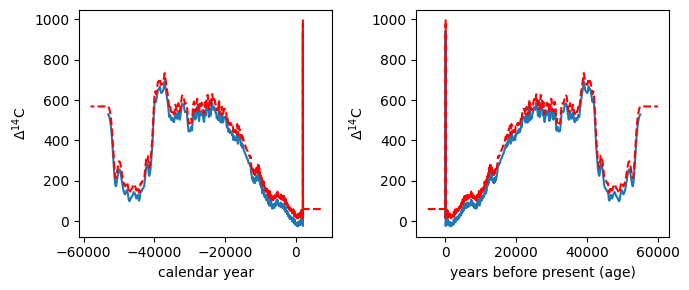

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
x_new = np.linspace(C14_DATA.years_before_present.min()-5000, C14_DATA.years_before_present.max()+5000, 100000)
y_new = INTERP_14C(x_new)

plt.sca(axs[0])
plt.plot(C14_DATA.year, C14_DATA.Delta_14C)
plt.plot(-1*(x_new - C14_DATA.year.max()), y_new + 40, color='r', linestyle='--')
plt.xlabel('calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.sca(axs[1])
plt.plot(C14_DATA.years_before_present, C14_DATA.Delta_14C)
plt.plot(x_new, y_new + 40, color='r', linestyle='--')
plt.xlabel('years before present (age)')
plt.ylabel('$\Delta^{14}$C')

plt.tight_layout()
plt.show()

In [3]:
pow_diskin = PowerLawDisKin(1, 1000)
T_int = integrate.quad(pow_diskin.mean_transit_time_integrand, 0, np.inf)
T_calc = pow_diskin.T
print('Calcualted transit time: ', T_calc)
print('Integrated transit time: ', T_int[0])

A_calc = pow_diskin.A
A_int = integrate.quad(pow_diskin.mean_age_integrand, 0, np.inf)
print('Calculated mean age: ', A_calc)
print('Integrated mean age: ', A_int[0])

Calcualted transit time:  6.337874070325488
Integrated transit time:  6.337874070325485
Calculated mean age:  156.7816139771682
Integrated mean age:  156.7816139771682


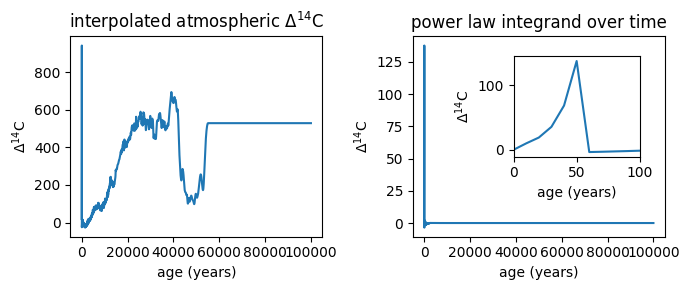

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

xs = np.linspace(0, 1e5, 10000)
integrand = [pow_diskin.radiocarbon_age_integrand(x) for x in xs]

plt.sca(axs[0])
plt.plot(xs, INTERP_14C(xs), label='14C')
plt.ylabel('$\Delta^{14}$C')
plt.xlabel('age (years)')
plt.title('interpolated atmospheric $\Delta^{14}$C')

plt.sca(axs[1])
plt.plot(xs, integrand, label='integrand')
plt.ylabel('$\Delta^{14}$C')
plt.xlabel('age (years)')
plt.title('power law integrand over time')

# Make an inset zooming in on the integrand for the first 100 years
axins = axs[1].inset_axes([0.4, 0.4, 0.5, 0.5])
axins.plot(xs, integrand)
axins.set_xlim(0, 100)
axins.set_xlabel('age (years)')
axins.set_ylabel('$\Delta^{14}$C')

plt.tight_layout()
plt.show()

In [ ]:
integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=10000)
               #epsabs=1e-5)


/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_78863/899380971.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=10000)


(1688.6736358035928, 1.1001803499548406)

In [6]:
# Sampling based integration
n_estimates = 1000
res = integrate.qmc_quad(pow_diskin.radiocarbon_age_integrand, 0, 1e6,
                         n_estimates=n_estimates, n_points=int(1e4))
res

QMCQuadResult(integral=1487.5380993218648, standard_error=108.17529415367484)

In [34]:
# Build a grid of tau_0 and tau_inf values
tau_0s = np.linspace(0, 10, 20)
tau_infs = np.linspace(1e3, 1e4, 20)

TAU_0, TAU_INF = np.meshgrid(tau_0s, tau_infs)
R = np.zeros((len(tau_0s), len(tau_infs)))

# Calculate the radiocarbon age for each pair of tau_0 and tau_inf
# and store the result in the R matrix
for i, tau_0 in enumerate(tau_0s):
    for j, tau_inf in enumerate(tau_infs):
        pow_diskin = PowerLawDisKin(tau_0, tau_inf)
        res = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf)
        R[i, j] = res[0]

/Users/flamholz/Documents/workspace/soil_diskin/notebooks/models.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  self.T = tau_0 * np.exp(self.tratio) * e1_term
/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_78863/3766075020.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf)
/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_78863/3766075020.py:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = integrate.quad(pow_diskin.radiocarbon

0.0 33497.811756061696


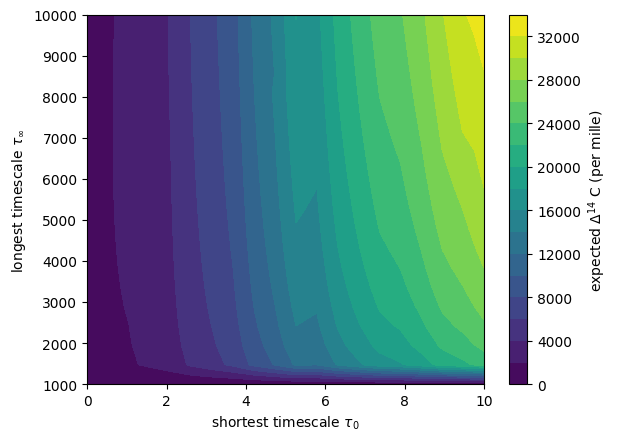

In [35]:
# contour plot with logarithmic color scale
plt.figure()

log_color_norm = LogNorm(vmin=1, vmax=R.max())
print(R.min(), R.max())

plt.contourf(TAU_0, TAU_INF, R, levels=20, cmap='viridis')
plt.colorbar().set_label('expected $\Delta^{14}$ C (per mille)')
plt.xlabel('shortest timescale $\\tau_0$')
plt.ylabel('longest timescale $\\tau_{\infty}$')
plt.show()